# Homework 3

> Subject sentence

In [ ]:
#hide
import numpy as np
import csv
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1.  In homework 2, we cross-validated a kernel density estimator by (probably) maximizing the leave-one-out likelihood/joint probability (maximize $\prod_{i=1}^n \hat{f}_{h,-i}(x_i)$ over $h$, yielding $h^*$).  

a. Argue that it makes more sense to maximize the sum of the log density estimates instead (ref: lecture 0).

It makes more sense to maximize the sum of log density estimates instead because, by page 265 in The Elements of Statistical Learning, maximum likelihood is based on the likelihood function; we choose the value of $\theta = \hat{\theta}$ that maximizes the loss $\mathcal{L}$. However, this loss function is difficult to differentiate. Moreover, we know that the log function is a monotonically increasing function, meaning if the value on the x-axis increases, then the value on the y-axis also increases. Hence, the maximum value of the log of the likelihood occurs at the same point as the maximum value of the likelihood. Lastly, since the log of products is the sum of logs, we have simiplified the task.

b. Suppose that you will observe a second sample of the size $n$ as your future data.  How will the likelihood of this data ($\prod_{j=n+1}^{2n} \hat{f}_{h^*}(x_j))$) likely compare to the value of the cross validated leave-one-out likelihood? Why?  (You can check this with code easily, but it won't tell you why.  The answer is related to the reason we do cross-validation in the first place). 

By page 265 in The Elements of Statistical Learning, leave-one-out cross-validation has low bias but can have high variance. 

2. Estimate the Air Quality at Estlla Hall (point 10 in the AQI data set) using a 2-$d$ kernel regression smoother based on data taken from purpleair.com.  If you use a 
"circular" bandwidth via a bivariate normal kernel, 
then the weights are just the product of the univariate kernel: if $w=(x,y)$ then $K_2(\frac{\|w_i-w\|}{h})=K_1(\frac{x_i-x}{h})K_1(\frac{y_i-y}{h})$, where $K_2$ is the bivariate normal kernel and $K_1$ is a univariate normal kernel.  (If you've taken probability, state why this is true.  What is a "circular" bandwidth equivalent to?)    

If you want to use something other than an ellipse with axis corresponding to the Lat/Lon axes, you can use the *dmvnorm* function in the **mvtnorm** package.  But I think the topography of this area lends itself nicely to the standard axes (though not necessarily circular neighborhoods).  

Cross-validate only if you want to.  

```{r}
aqi <- read.csv("~/154/hw3aqidata")  #you'll need to add this to your workspace
stations <- aqi[1:9,]
par(bg = "blanchedalmond")
plot(c(0,2), c(-8,3), t='n')
points(stations$x, stations$y, cex=4)
for (i in 1:nrow(stations))
  legend(stations$x[i]-.125, stations$y[i]+.6, stations$z[i], bty='n') #hack!
points(aqi$x[10], aqi$y[10], cex=4)
legend(aqi$x[10]-.155, aqi$y[10]+.6, c(' ?'), bty='n')
```
Note:  I got this data set as well as the XKCD data set using this tool: https://apps.automeris.io/wpd/


In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd
path_to_data = "../data/hw3aqidata.csv"
aqi = pd.read_csv(path_to_data);
stations = aqi[1:9]
stations
X, y = [[x] for x in aqi['x']], aqi['y']

In [19]:
import time
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn_extensions.kernel_regression import KernelRegression


# Fit regression models
svr = GridSearchCV(SVR(kernel='rbf'), cv=5, param_grid={"C": [1e-1, 1e0, 1e1, 1e2], "gamma": np.logspace(-2, 2, 10)})

kr = KernelRegression(kernel="rbf", gamma=np.logspace(-2, 2, 10))
t0 = time.time()
y_svr = svr.fit(X, y).predict(X)

print("SVR complexity and bandwidth selected and model fitted in %.3f s" % (time.time() - t0))

t0 = time.time()
y_kr = kr.fit(X, y).predict(X)

print("KR including bandwith fitted in %.3f s" % (time.time() - t0))

SVR complexity and bandwidth selected and model fitted in 0.269 s
KR including bandwith fitted in 0.091 s


/gpfs/ysm/project/sumry2022/sumry2022_ta483/conda_envs/m154/lib/python3.7/site-packages/sklearn_extensions/kernel_regression/kr.py:93: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Ky = K * self.y[:, np.newaxis]
/gpfs/ysm/project/sumry2022/sumry2022_ta483/conda_envs/m154/lib/python3.7/site-packages/sklearn_extensions/kernel_regression/kr.py:93: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Ky = K * self.y[:, np.newaxis]
/gpfs/ysm/project/sumry2022/sumry2022_ta483/conda_envs/m154/lib/python3.7/site-packages/sklearn_extensions/kernel_regression/kr.py:93: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before i

3.  The end of the first lab describes additive models and the back-fitting algorithm.  This model allows a high dimensional regression function to be estimated by recursively taking projections of your data to create bivariate data sets where the smoother from Lecture 2 can be used, thus avoiding the curse of dimensionality (at the cost of restricting the flexibility of your learner however).

Implement this algorithm and fit the following data set ($x_1, x_2, y$) with the true response surface visualized. 
```{r}
set.seed(47)
x1 <- runif(200)
x2 <- runif(200)
y <- 5 + x1^2 + sin(x2*10) + rnorm(200,0, .3)
grid <- seq(0,1,.01)
truth <- matrix(0, nrow=length(grid), ncol=length(grid))
for (i in 1:length(grid)){
  for (j in 1:length(grid)) {
    truth[i,j] <- 5 + grid[i]^2 + sin(grid[j]*10)
  }
}
image(grid,grid,truth)  #heat map
persp(truth, theta=45) #persepctive plot
```
You can either present a plot of the complete estimated regression surface, or plots of the individual estimates $\hat{s}_i(x_i)$ which completely characterize the surface under the additivity assumption. 

In [18]:
from pygam import LinearGAM, s, f
import numpy as np

x1 = np.random.uniform(0,1,200)
x2 = np.random.uniform(0,1,200)
y = 5 + x1**2 + np.sin(x2)*10 + np.random.normal(0, np.sqrt(0.3))
X = np.vstack((x1, x2)).T

In [24]:
## model
gam = LinearGAM(s(0) + s(1))
gam.gridsearch(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

<Figure size 640x480 with 0 Axes>

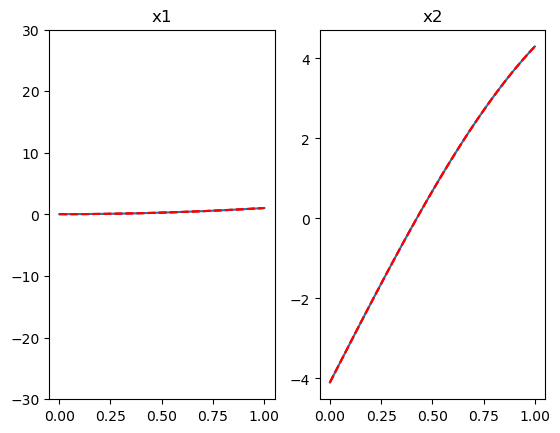

In [25]:
import matplotlib.pyplot as plt
## plotting
plt.figure();
fig, axs = plt.subplots(1,2);

titles = ['x1', 'x2']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);